# Basic Setup

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [13]:
file_path = '/Users/yarden/Documents/Atuda/spring_2024/causal_inference/Causal-Inference-Project-Effect-of-Age-on-Graduating/code/data/processed_data.csv'
data = pd.read_csv(file_path)

data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Admission grade,Displaced,Educational special needs,Gender,Scholarship holder,Unemployment rate,Inflation rate,GDP,Target,Adult
0,1,17,5,171,1,Complete Secondary Education,122.0,Incomplete Secondary Education,Complete Secondary Education,Administrative,...,127.3,1,0,1,0,10.8,1.4,1.74,0,0
1,1,15,1,9254,1,Complete Secondary Education,160.0,Complete Secondary Education,Higher Education - Undergraduate,Professionals,...,142.5,1,0,1,0,13.9,-0.3,0.79,1,0
2,1,1,5,9070,1,Complete Secondary Education,122.0,Other Specific Qualifications,Other Specific Qualifications,Plant and Machine Operators,...,124.8,1,0,1,0,10.8,1.4,1.74,0,0
3,1,17,2,9773,1,Complete Secondary Education,122.0,Other Specific Qualifications,Other Specific Qualifications,Administrative,...,119.6,1,0,0,0,9.4,-0.8,-3.12,1,0
4,2,39,1,8014,0,Complete Secondary Education,100.0,Other Specific Qualifications,Other Specific Qualifications,Plant and Machine Operators,...,141.5,0,0,0,0,13.9,-0.3,0.79,1,1


In [14]:
n = len(data)

t = data['Adult']
y = data['Target']
X = data.drop(columns=['Adult', 'Target'])

numerical_columns = ['Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 'Inflation rate', 'GDP']
categorical_columns = list(set(X.columns) - set(numerical_columns))

# Scaling numerical columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# One-hot encoding for categorical columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Combine features and treatment variable to create the full feature set
X_full = pd.concat([X, t], axis=1)

# ROC Curve for $Y \mid X, t$

/Users/yarden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


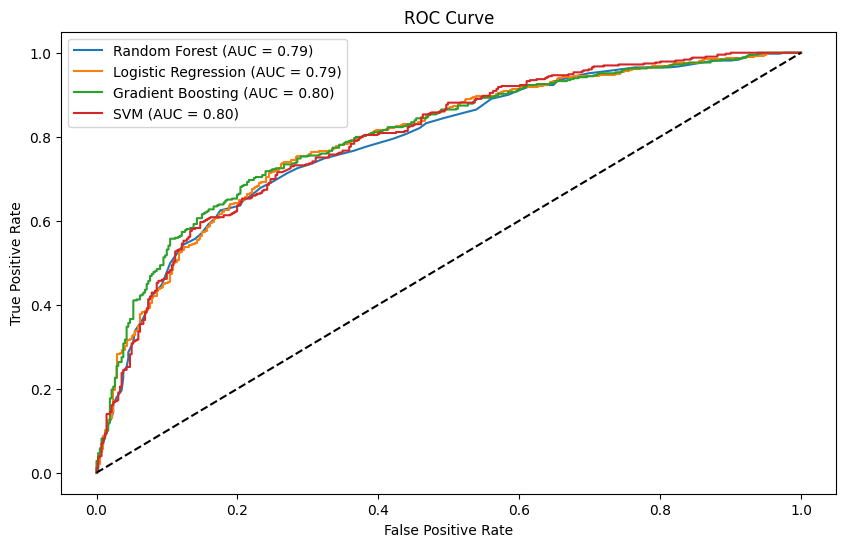

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Fit a Random Forest Classifier model to predict the target variable
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Fit a Logistic Regression model to predict the target variable
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Fit a Gradient Boosting Classifier model to predict the target variable
model_gb = GradientBoostingClassifier(random_state=42)   
model_gb.fit(X_train, y_train)

# Fit an SVM model to predict the target variable
model_svm = SVC(probability=True, random_state=42)
model_svm.fit(X_train, y_train)


# Make predictions for test data 
y_pred_rf = model_rf.predict_proba(X_test)[:, 1]
y_pred_lr = model_lr.predict_proba(X_test)[:, 1]
y_pred_gb = model_gb.predict_proba(X_test)[:, 1]
y_pred_svm = model_svm.predict_proba(X_test)[:, 1]

# Calculate the ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

# Calculate the ROC curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)

# Calculate the ROC curve for Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_gb)

# Calculate the ROC curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

We observe that Random Forest, Gradient Boosting and SVM have the highest AUC.

# ROC Curve $T \mid X$

/Users/yarden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


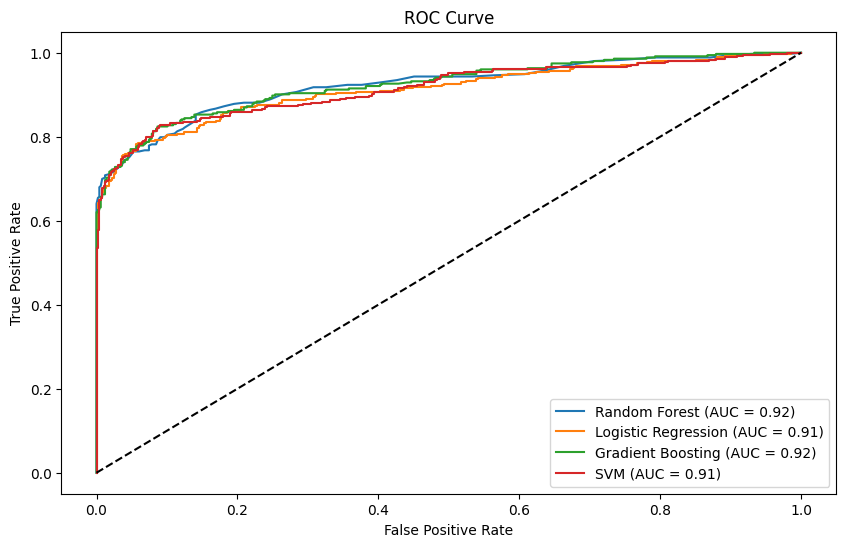

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, random_state=42)

# Fit a Random Forest Classifier model to predict the treatment variable
model_rf_t = RandomForestClassifier(random_state=42)
model_rf_t.fit(X_train, y_train)

# Fit a Logistic Regression model to predict the treatment variable
model_lr_t = LogisticRegression(random_state=42)
model_lr_t.fit(X_train, y_train)

# Fit a Gradient Boosting Classifier model to predict the treatment variable
model_gb_t = GradientBoostingClassifier(random_state=42)
model_gb_t.fit(X_train, y_train)

# Fit an SVM model to predict the treatment variable
model_svm_t = SVC(probability=True, random_state=42)
model_svm_t.fit(X_train, y_train)

# Make predictions for test data
y_pred_rf_t = model_rf_t.predict_proba(X_test)[:, 1]
y_pred_lr_t = model_lr_t.predict_proba(X_test)[:, 1]
y_pred_gb_t = model_gb_t.predict_proba(X_test)[:, 1]
y_pred_svm_t = model_svm_t.predict_proba(X_test)[:, 1]

# Calculate the ROC curve for Random Forest
fpr_rf_t, tpr_rf_t, _ = roc_curve(y_test, y_pred_rf_t)
roc_auc_rf_t = roc_auc_score(y_test, y_pred_rf_t)

# Calculate the ROC curve for Logistic Regression
fpr_lr_t, tpr_lr_t, _ = roc_curve(y_test, y_pred_lr_t)
roc_auc_lr_t = roc_auc_score(y_test, y_pred_lr_t)

# Calculate the ROC curve for Gradient Boosting
fpr_gb_t, tpr_gb_t, _ = roc_curve(y_test, y_pred_gb_t)
roc_auc_gb_t = roc_auc_score(y_test, y_pred_gb_t)

# Calculate the ROC curve for SVM
fpr_svm_t, tpr_svm_t, _ = roc_curve(y_test, y_pred_svm_t)
roc_auc_svm_t = roc_auc_score(y_test, y_pred_svm_t)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf_t, tpr_rf_t, label=f'Random Forest (AUC = {roc_auc_rf_t:.2f})')
plt.plot(fpr_lr_t, tpr_lr_t, label=f'Logistic Regression (AUC = {roc_auc_lr_t:.2f})')
plt.plot(fpr_gb_t, tpr_gb_t, label=f'Gradient Boosting (AUC = {roc_auc_gb_t:.2f})')
plt.plot(fpr_svm_t, tpr_svm_t, label=f'SVM (AUC = {roc_auc_svm_t:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Covariate Adjustment

## S-learner

In [39]:
# Fit a Random Forest Classifier model to predict the target variable
model = RandomForestClassifier(random_state=42)
model.fit(X_full, y)    

# Make predictions for all data points
y_pred_all = model.predict(X_full)

In [40]:
# Filter predictions where Adult = 1 and Adult = 0
treated_predictions_sum = sum(y_pred_all[data['Adult'] == 1])
control_predictions_sum = sum(y_pred_all[data['Adult'] == 0])

# Calculate the desired value
ATE = (treated_predictions_sum - control_predictions_sum) / n
ATT = treated_predictions_sum / sum(t)
ATC = control_predictions_sum / (n - sum(t))

print(f'ATE: {ATE}')
print(f'ATT: {ATT}')
print(f'ATC: {ATC}')

ATE: -0.20169451635678984
ATT: 0.3598420755781162
ATC: 0.6037964458804523


## T-learner

In [41]:
X_1 = X[X_full['Adult'] == 1]
X_0 = X[X_full['Adult'] == 0]

y_1 = data[data['Adult'] == 1]['Target']
y_0 = data[data['Adult'] == 0]['Target']

# Fit a Random Forest Classifier model to predict the target variable for each subgroup
model_1 = RandomForestClassifier(random_state=42)
model_1.fit(X_1, y_1)

model_0 = RandomForestClassifier(random_state=42)
model_0.fit(X_0, y_0)

y_pred_all_1 = model_1.predict(X)
y_pred_all_0 = model_0.predict(X)

In [42]:
treated_predictions_sum = sum(y_pred_all_1)
control_predictions_sum = sum(y_pred_all_0)

ATE = (treated_predictions_sum - control_predictions_sum) / n
ATT = (sum(y_pred_all_1[data['Adult'] == 1]) -  sum(y_pred_all_0[data['Adult'] == 1])) / sum(t)
ATC = (sum(y_pred_all_1[data['Adult'] == 0]) -  sum(y_pred_all_0[data['Adult'] == 0])) / (n - sum(t))
                                 
print(f'ATE: {ATE}')
print(f'ATT: {ATT}')
print(f'ATC: {ATC}')

ATE: -0.13673805601317957
ATT: -0.13761985335589397
ATC: -0.13610662358642972


# IPW

In [46]:
# Fit a Logistic Regression model to predict the treatment variable
propensity_model = LogisticRegression(random_state=42)
propensity_model.fit(X, t)

# Calculate the propensity scores (predicted probabilities of receiving the treatment)
e = propensity_model.predict_proba(X)[:, 1]

# Add the propensity scores to the original data
data['propensity_score'] = e
print(e)

[0.21380405 0.12952125 0.25933854 ... 0.10312549 0.04206471 0.08348846]


/Users/yarden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
ATE = sum(y * t / e) / n - sum(y * (1 - t) / (1 - e)) / n
ATT = sum(y * t) / sum(t) - sum(y * (1 - t) * e / (1 - e)) / sum((1 - t) * e / (1 - e))
ATC = sum(y * t * (1 - e) / e) / sum(t * (1 - e) / e) - sum(y * (1 - t)) / sum(1 - t)

print(f'ATE: {ATE}')
print(f'ATT: {ATT}')
print(f'ATC: {ATC}')

ATE: 0.019604997526394996
ATT: -0.05339414357951483
ATC: -0.05115850321706916


# Propensity Score Matching

In [23]:
treated = data[data['Adult'] == 1]
control = data[data['Adult'] == 0]

In [24]:
def nearest_neighbor_match(treated, control, treatment_outcome, control_outcome):
    matched_outcomes = []
    
    # Loop over each treated individual
    for i, treated_row in treated.iterrows():
        # Find the control individual with the closest propensity score
        control_row = control.iloc[(control['propensity_score'] - treated_row['propensity_score']).abs().argsort()[:1]]
        
        # Calculate the difference in outcomes
        matched_outcomes.append(treated_row[treatment_outcome] - control_row[control_outcome].values[0])
    
    return matched_outcomes

In [25]:
att_differences = nearest_neighbor_match(treated, control, 'Target', 'Target')
ATT = sum(att_differences) / len(att_differences)

atc_differences = nearest_neighbor_match(control, treated, 'Target', 'Target')
ATC = sum(atc_differences) / len(atc_differences)

p = sum(data['Adult']) / n
ATE = p * ATT + (1 - p) * ATC

print(f'ATE: {ATE}')
print(f'ATT: {ATT}')
print(f'ATC: {ATC}')

ATE: 0.07813603200753118
ATT: 0.16130851663846588
ATC: 0.018578352180936994


# Doubly Robust Estimator

In [51]:
X_1 = X[X_full['Adult'] == 1]
X_0 = X[X_full['Adult'] == 0]

y_1 = data[data['Adult'] == 1]['Target']
y_0 = data[data['Adult'] == 0]['Target']

# Fit a Random Forest Classifier model to predict the target variable for each subgroup
model_1 = RandomForestClassifier(random_state=42)
model_1.fit(X_1, y_1)

model_0 = RandomForestClassifier(random_state=42)
model_0.fit(X_0, y_0)

y_pred_all_1 = model_1.predict(X)
y_pred_all_0 = model_0.predict(X)

g_1_score = y_pred_all_1 + (t / e) * (y - y_pred_all_1)
g_0_score = y_pred_all_0 + ((1 - t) / (1 - e)) * (y - y_pred_all_0)

data['g_1_score'] = g_1_score
data['g_0_score'] = g_0_score

In [52]:
ATE = sum(data['g_1_score']) / n - sum(data['g_0_score']) / n
ATT = sum(t * y - ((t - e) * y_pred_all_0 / (1 - e))) / sum(t)
ATC = sum((1 - e) * t * y / e - ((t - e) * y_pred_all_1 / e) - ((1 - t) * y)) / sum(1 - t)

print(f'ATE: {ATE}')
print(f'ATT: {ATT}')
print(f'ATC: {ATC}')

ATE: -0.13673805601317957
ATT: 0.05857950285547217
ATC: -0.13610662358642972
